# import library

In [ ]:
# matplotlib 한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Kaier_Tofu_Data')

In [ ]:

import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import normalize
from os import listdir
from os.path import join
import Resnet
import random
from tqdm import tqdm
import cv2
from torchvision import transforms
from Common import get_rmac_region_coordinates
from Common import pack_regions_for_network
from Common import RoIPool
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [ ]:

import copy
import time
import math
import torch.utils.model_zoo as model_zoo

import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset




In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet


# Load tofu datasets

In [ ]:
def train_test_numpy_load(data_path,train_path,valid_path,test_path,saved_path,load):
    
    if load:
        with open(os.path.join(saved_path,'train_image.pickle'), 'rb') as f:
            train_image = pickle.load(f)
        with open(os.path.join(saved_path,'train_class.pickle'), 'rb') as f:
            train_class = pickle.load(f)
        with open(os.path.join(saved_path,'valid_image.pickle'), 'rb') as f:
            valid_image = pickle.load(f)
        with open(os.path.join(saved_path,'valid_class.pickle'), 'rb') as f:
            valid_class = pickle.load(f)
        with open(os.path.join(saved_path,'test_image.pickle'), 'rb') as f:
            test_image = pickle.load(f)
        with open(os.path.join(saved_path,'test_class.pickle'), 'rb') as f:
            test_class = pickle.load(f)
        return train_image, train_class, valid_image, valid_class, test_image, test_class 
    
    folders = ['정상A', '정상B', '금속', '머리카락', '벌레', '상단불량D', '상단불량E', '유바', '탄화물', '플라스틱']
    
    train_image_list = [] 
    train_class = []    
    valid_image_list = []
    valid_class = []
    test_image_list = []
    test_class = []
    for fold in tqdm(folders):
        fpattern = os.path.join(data_path, f'{train_path}/{fold}/*.jpg')
        train_file_list = sorted(glob(fpattern))
        fpattern = os.path.join(data_path, f'{valid_path}/{fold}/*.jpg')
        valid_file_list = sorted(glob(fpattern))
        fpattern = os.path.join(data_path, f'{test_path}/{fold}/*.jpg')
        test_file_list = sorted(glob(fpattern))     
        print()
        print("train {} starting..." .format(fold))
        for train_file in (train_file_list):
            train_image = np.asarray(Image.open(train_file).resize((224,224)))
            train_image_list.append(train_image)
        print("train {} finished..." .format(fold))
        print("valid {} starting..." .format(fold))
        for valid_file in (valid_file_list):
            valid_image = np.asarray(Image.open(valid_file).resize((224,224)))
            valid_image_list.append(valid_image)
        print("valid {} finished..." .format(fold))
        print("test {} starting..." .format(fold))
        for test_file in (test_file_list):                  
            test_image = np.asarray(Image.open(test_file).resize((224,224)))           
            test_image_list.append(test_image)
        print("test {} finished..." .format(fold))
        train_class += [fold]*len(train_file_list)
        valid_class += [fold]*len(valid_file_list)
        test_class += [fold]*len(test_file_list)
        
    np_train_image = np.array(train_image_list)
    np_valid_image = np.array(valid_image_list)
    np_test_image = np.array(test_image_list)

    with open(os.path.join(saved_path,'train_image.pickle'),'wb') as f:
        pickle.dump(np_train_image,f)
    with open(os.path.join(saved_path,'train_class.pickle'),'wb') as f:
        pickle.dump(train_class,f)
    with open(os.path.join(saved_path,'valid_image.pickle'),'wb') as f:
        pickle.dump(np_valid_image,f)
    with open(os.path.join(saved_path,'valid_class.pickle'),'wb') as f:
        pickle.dump(valid_class,f)
    with open(os.path.join(saved_path,'test_image.pickle'),'wb') as f:
        pickle.dump(np_test_image,f)
    with open(os.path.join(saved_path,'test_class.pickle'),'wb') as f:
        pickle.dump(test_class,f)     
    return np_train_image, train_class, np_valid_image, valid_class, np_test_image, test_class

In [ ]:
import pickle
data_path = '/content/drive/MyDrive/Kaier_Tofu_Data'
train_path = 'train'
valid_path = 'valid'
test_path = 'test_1345'
saved_path = '/content/drive/MyDrive/Kaier_Tofu_Data'
load = True
train_image, train_class, valid_image, valid_class, test_image, test_class = train_test_numpy_load(data_path,train_path,valid_path,test_path,saved_path,load)


In [ ]:
print("train image size: {}" .format(train_image.shape))
print("valid image size: {}" .format(valid_image.shape))
print("test image size: {}" .format(test_image.shape))

train image size: (16793, 224, 224, 3)
valid image size: (1862, 224, 224, 3)
test image size: (8367, 224, 224, 3)


In [ ]:
print("train class length: {}" .format(len(train_class)))
print("valid class length: {}" .format(len(valid_class)))
print("test class length: {}" .format(len(test_class)))

train class length: 16793
valid class length: 1862
test class length: 8367


In [ ]:
train_class_counts = np.unique(train_class, return_counts=True)
print("train class counts")
print("------------------")
for name, counts in zip(train_class_counts[0], train_class_counts[1]):
  print("{} has {} data points" .format(name, counts))

  

train class counts
------------------
금속 has 519 data points
머리카락 has 649 data points
벌레 has 543 data points
상단불량D has 1255 data points
상단불량E has 1094 data points
유바 has 982 data points
정상A has 6318 data points
정상B has 4266 data points
탄화물 has 644 data points
플라스틱 has 523 data points


In [ ]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()

In [ ]:
train_label = le.fit_transform(train_class)
valid_label = le.transform(valid_class)
test_label = le.transform(test_class)

In [ ]:
NUM_CLASSES = 10
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [ ]:
class TofuDataset(Dataset):

    def __init__(self,  data=None, label=None, transform=None):

        self.transform = transform

        self.data = data
        self.label = label      


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.label[index]
        
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)   # (batch, channel, width*height)
        mean += data.mean(2).sum(0)   # 각 채널별로 평균값 구하고 배치 사이즈만큼에 대해서 더함 # shape: (channel)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

In [ ]:
# 이미지 데이터셋에 대해서 각 채널별로 mean, std 구하기 

batch_size = 512

train_transforms = transforms.Compose([                                       
                                        transforms.ToTensor()])  #ToTensor: [0,255] -> [0,1] range 변환

train_data = TofuDataset(data=train_image, label=train_label, transform=train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
# mean,std = normalization_parameter(train_loader)

# print(mean,std)

In [ ]:
# print(mean,std)
mean = [0.39665315 ,0.40428504 ,0.38178203]
std = [0.14272803, 0.14405888 ,0.0868382 ]

In [ ]:
transform = transforms.Compose([                                

                                transforms.RandomRotation(degrees=15),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomAutocontrast(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)])

In [ ]:
train_dataset = TofuDataset(data=train_image, label=train_label, transform=train_transforms)
valid_dataset = TofuDataset(data = valid_image, label=valid_label, transform=train_transforms)
test_dataset = TofuDataset(data=test_image, label=test_label, transform=train_transforms)

In [ ]:
batch_size=64
dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
dataloaders['val'] = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

In [ ]:
#check dataloader shape

for img, label in dataloaders['train']:
  print(img.shape)
  print(label)
  break

torch.Size([64, 3, 224, 224])
tensor([6, 7, 7, 6, 6, 9, 7, 7, 6, 6, 7, 6, 6, 6, 7, 7, 4, 6, 3, 7, 6, 4, 1, 8,
        7, 0, 7, 7, 4, 6, 2, 6, 4, 5, 6, 6, 9, 6, 6, 5, 6, 7, 6, 4, 4, 6, 6, 7,
        4, 0, 5, 6, 6, 7, 6, 6, 4, 7, 6, 7, 6, 6, 2, 6])


# model

In [ ]:
class ContextAwareRegionalAttentionNetwork(nn.Module):
    def __init__(self, spatial_scale, pooled_height = 1, pooled_width = 1):
        super(ContextAwareRegionalAttentionNetwork, self).__init__()
        self.pooled_width = int(pooled_width)
        self.pooled_height = int(pooled_height)
        self.spatial_scale = float(spatial_scale)
        
        self.conv_att_1 = nn.Conv1d(2560, 64, 1, padding=0)
        self.sp_att_1 = nn.Softplus()
        self.conv_att_2 = nn.Conv1d(64, 1, 1, padding=0)
        self.sp_att_2 = nn.Softplus()
        

    def forward(self, features, rois):
   
        batch_size, num_channels, data_height, data_width = features.size()
        num_rois = rois.size()[0]
        
        outputs = Variable(torch.zeros(num_rois, num_channels*2,
                                       self.pooled_height,
                                       self.pooled_width))
        if features.is_cuda:
            outputs = outputs.cuda(torch.cuda.device_of(features).idx)
            
        # Based on roi pooling code of pytorch but, the only difference is to change max pooling to mean pooling
        for roi_ind, roi in enumerate(rois):
            batch_ind = int(roi[0].data)
            roi_start_w, roi_start_h, roi_end_w, roi_end_h = roi_start_w, roi_start_h, roi_end_w, roi_end_h = torch.round(roi[1:]* self.spatial_scale).data.cpu().numpy().astype(int)
            roi_width = max(roi_end_w - roi_start_w + 1, 1)
            roi_height = max(roi_end_h - roi_start_h + 1, 1)
            bin_size_w = float(roi_width) / float(self.pooled_width)
            bin_size_h = float(roi_height) / float(self.pooled_height)

            for ph in range(self.pooled_height):
                hstart = int(np.floor(ph * bin_size_h))
                hend = int(np.ceil((ph + 1) * bin_size_h))
                hstart = min(data_height, max(0, hstart + roi_start_h))
                hend = min(data_height, max(0, hend + roi_start_h))
                for pw in range(self.pooled_width):
                    wstart = int(np.floor(pw * bin_size_w))
                    wend = int(np.ceil((pw + 1) * bin_size_w))
                    wstart = min(data_width, max(0, wstart + roi_start_w))
                    wend = min(data_width, max(0, wend + roi_start_w))

                    is_empty = (hend <= hstart) or(wend <= wstart)
                    if is_empty:
                        outputs[roi_ind, :, ph, pw] = 0
                    else:
                        data = features[batch_ind]
                        # mean pooling with both of regional feature map and global feature map
                        outputs[roi_ind, :, ph, pw] = torch.cat((torch.mean(
                            torch.mean(data[:, hstart:hend, wstart:wend], 1, keepdim = True), 2, keepdim = True).view(-1)
                            ,torch.mean(
                            torch.mean(data, 1, keepdim = True), 2, keepdim = True).view(-1)), 0 )  # noqa
        
        # Reshpae
        outputs = outputs.squeeze(2).squeeze(2)
        outputs = outputs.transpose(0,1).unsqueeze(0) # (1, # channel, #batch * # regions)
        #Calculate regional attention weights with context-aware regional feature vectors
        k = self.sp_att_1(self.conv_att_1(outputs))
        k = self.sp_att_2(self.conv_att_2(k)) # (1, 1, #batch * # regions)
        k = torch.squeeze(k,1)
        
        return k



class NetForTraining(nn.Module):


    def __init__(self):
        super(NetForTraining, self).__init__()
        
        #RoI max pooling
        self.r_mac_pool = RoIPool(1,1,0.03125)
        self.region_attention = ContextAwareRegionalAttentionNetwork(spatial_scale = 0.03125)
        self._initialize_weights()
        
        # This is for classification. get the weights of fc from off-the-shelf efficientnet B0
        # (featrue vector, number of classes)
        self.fc = nn.Linear(1280,10)   

        # Load efficientnet model
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)  
        self.efficientnet.load_state_dict(torch.load('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/raw_data_president_model.pt'))
        
        for param in self.efficientnet.parameters():
            param.requires_grad = False

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
   
    def forward(self, x, ):
        
        # Calculate R-MAC regions (Region sampling)
        batched_rois =  [get_rmac_region_coordinates(x.shape[2],x.shape[3],5) for i in range(x.shape[0])]   # (batch size(5), # of proposed region(55), coordinates?(4))
        region_size = len(batched_rois[0])
        rois = Variable(torch.FloatTensor(pack_regions_for_network(batched_rois))) # [220(55*4), 5]

        h = x

        # Extract feature map
        h = self.efficientnet.extract_features(x) #( #batch, #channel, #h, #w)  # [4, 1280, 7, 7]

        g = self.r_mac_pool(h,rois)  # [220, 1280, 1, 1]
        g = g.squeeze(2).squeeze(2)  # [220, 1280]

        g2 = self.region_attention(h,rois)
        g2 = g2.squeeze(0).squeeze(0)# (# batch * region)

        g = torch.mul(g.transpose(1,0),g2).transpose(1,0)
        
        # regional weighted feature (# batch * region, #channel)
        
        g = g.contiguous()
        g = g.view(torch.Size([h.size(0), -1 ,h.size(1)])) # (#batch, # region, # channel)
        g = torch.transpose(g,1,2)    # (#batch * #channel, #region)
        

        g = torch.mean(g,2) #mean?

        g = self.fc(g)

        return g


In [ ]:
net = NetForTraining()

dic = torch.load('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/raw_data_president_model.pt')
net.fc.weight.data = dic['_fc.weight']
net.fc.bias.data = dic['_fc.bias']

for param in net.fc.parameters():
    param.requires_grad=False
# net.eval()
net = net.cuda(0)

for name,param in net.named_parameters():
    if param.requires_grad == True:
        print(name)

# Train only regional attention network
init_lr = 0.001
optimizer_ft = optim.SGD(list(net.parameters())[:4], lr=init_lr, momentum=0.9, weight_decay = 0.00005)
criterion =nn.CrossEntropyLoss()


Loaded pretrained weights for efficientnet-b0
region_attention.conv_att_1.weight
region_attention.conv_att_1.bias
region_attention.conv_att_2.weight
region_attention.conv_att_2.bias


In [ ]:
print(net.state_dict().keys())

odict_keys(['region_attention.conv_att_1.weight', 'region_attention.conv_att_1.bias', 'region_attention.conv_att_2.weight', 'region_attention.conv_att_2.bias', 'fc.weight', 'fc.bias', 'efficientnet._conv_stem.weight', 'efficientnet._bn0.weight', 'efficientnet._bn0.bias', 'efficientnet._bn0.running_mean', 'efficientnet._bn0.running_var', 'efficientnet._bn0.num_batches_tracked', 'efficientnet._blocks.0._depthwise_conv.weight', 'efficientnet._blocks.0._bn1.weight', 'efficientnet._blocks.0._bn1.bias', 'efficientnet._blocks.0._bn1.running_mean', 'efficientnet._blocks.0._bn1.running_var', 'efficientnet._blocks.0._bn1.num_batches_tracked', 'efficientnet._blocks.0._se_reduce.weight', 'efficientnet._blocks.0._se_reduce.bias', 'efficientnet._blocks.0._se_expand.weight', 'efficientnet._blocks.0._se_expand.bias', 'efficientnet._blocks.0._project_conv.weight', 'efficientnet._blocks.0._bn2.weight', 'efficientnet._blocks.0._bn2.bias', 'efficientnet._blocks.0._bn2.running_mean', 'efficientnet._blocks.

In [ ]:
dic = torch.load('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/raw_data_president_model.pt')

In [ ]:
dic['_fc.weight'].shape

torch.Size([10, 1280])

In [ ]:
import numpy as np
import torch 

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). \
                 Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:

# make early_stopping object 
early_stopping = EarlyStopping(patience = 15, verbose = True)

# train 

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100):
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss' : [], 'val_loss' :[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
#         scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs.data, 1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                
                running_corrects += torch.sum(preds == labels.data)
           
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset))*100
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        early_stopping(-auc_score, net)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_ft, hist = train_model(net, dataloaders, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0000 Acc: 99.9345
val Loss: 0.0182 Acc: 90.2793

Epoch 1/9
----------
train Loss: 0.0001 Acc: 99.8571
val Loss: 0.0162 Acc: 90.1182

Epoch 2/9
----------
train Loss: 0.0001 Acc: 99.8749
val Loss: 0.0154 Acc: 90.1719

Epoch 3/9
----------
train Loss: 0.0001 Acc: 99.8809
val Loss: 0.0152 Acc: 90.1719

Epoch 4/9
----------
train Loss: 0.0001 Acc: 99.8749
val Loss: 0.0150 Acc: 90.1719

Epoch 5/9
----------
train Loss: 0.0000 Acc: 99.9345
val Loss: 0.0157 Acc: 90.3330

Epoch 6/9
----------
train Loss: 0.0000 Acc: 99.9464
val Loss: 0.0175 Acc: 90.3867

Epoch 7/9
----------
train Loss: 0.0001 Acc: 99.8928
val Loss: 0.0171 Acc: 90.3330

Epoch 8/9
----------
train Loss: 0.0001 Acc: 99.8988
val Loss: 0.0162 Acc: 90.1719

Epoch 9/9
----------
train Loss: 0.0000 Acc: 99.9107
val Loss: 0.0181 Acc: 90.2793

Training complete in 53m 34s
Best val Acc: 90.386681


In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/regional_attention_efficientnet.pt')
print('model saved')

model saved


# Test 

In [ ]:
# load model 
net.load_state_dict(torch.load('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/regional_attention_efficientnet.pt'))

<All keys matched successfully>

In [ ]:
# predict over tofu test datasets

device = 'cuda:0'
net = net.to(device)

net.eval() 
phase = 'test'

pred_list = []
true_list = []

with torch.no_grad():
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
   
        pred_list += preds.cpu().tolist()
        true_list += labels.cpu().tolist()



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_list, pred_list)

0.8724752001912275

In [ ]:
# class별 accuracy 
class_names = ['정상A', '정상B', '금속', '머리카락', '벌레', '상단불량D', '상단불량E', '유바', '탄화물', '플라스틱']
class_accuracy = dict()
for class_ in class_names:
  idx = np.in1d(test_class, class_)
  class_tmp = (np.array(true_list)==np.array(pred_list))[idx]
  accruacy_ = np.sum(class_tmp) / len(class_tmp)
  class_accuracy[class_] = accruacy_
class_accuracy
  

{'금속': 0.72,
 '머리카락': 0.9692307692307692,
 '벌레': 0.83,
 '상단불량D': 0.6420845624385447,
 '상단불량E': 0.9147540983606557,
 '유바': 0.8777777777777778,
 '정상A': 0.913659793814433,
 '정상B': 0.9025893958076449,
 '탄화물': 0.8114754098360656,
 '플라스틱': 0.89}

In [ ]:
le_name_mapping = dict(zip(le.transform(le.classes_),le.classes_))
#le_name_mapping

In [ ]:
predict_class_list = [le_name_mapping[x] for x in pred_list]
test_class_list = [le_name_mapping[x] for x in true_list]


In [ ]:
!pip install scikit-plot

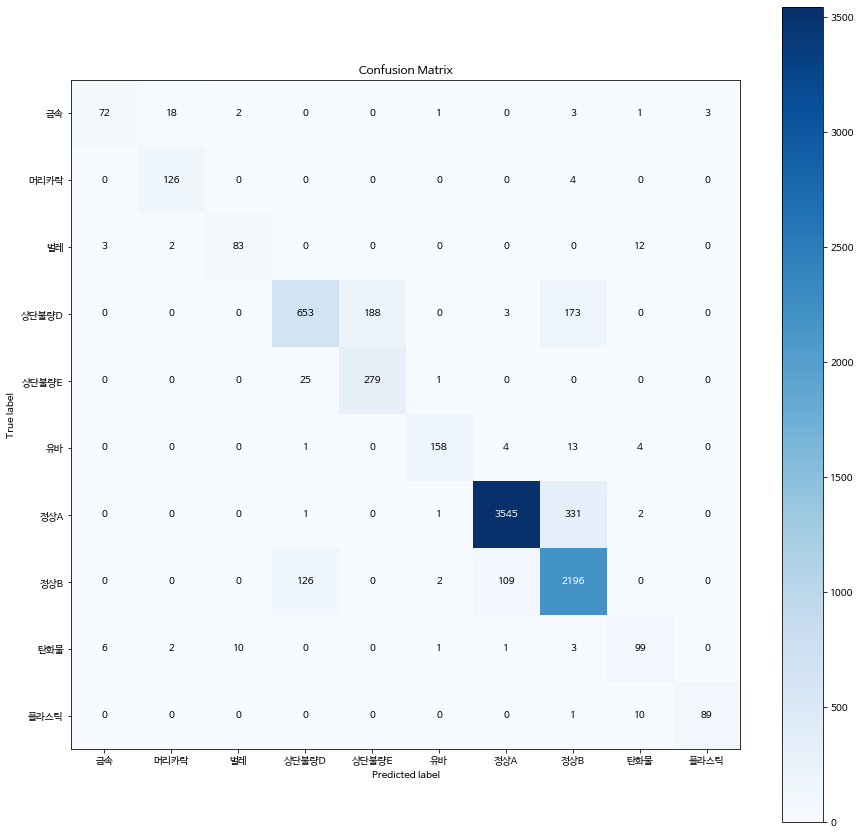

In [ ]:
# confusion matrix 
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test_class_list, predict_class_list, figsize=(15,15))
#plt.savefig("confusion_matrix_normalized2.png")


In [ ]:
# 과검 test

from PIL import Image
normal_class = ['정상A', '정상B']
upper_class = ['상단불량D', '상단불량E']
foreign_substance_class =  ['금속', '머리카락', '벌레', '유바', '탄화물', '플라스틱']
total_class = [normal_class] +[upper_class]+ [foreign_substance_class] 

for i, class_ in enumerate(total_class):
  idx_ = np.in1d(test_class, class_)

  predict_class = np.array(predict_class_list)[idx_]
  #true_class = np.array(test_class_list)[idx_]
  print(np.unique(predict_class, return_counts=True))
  print(len(predict_class))
  print(class_)
  print()


(array(['상단불량D', '유바', '정상A', '정상B', '탄화물'], dtype='<U5'), array([ 127,    3, 3654, 2527,    2]))
6313
['정상A', '정상B']

(array(['상단불량D', '상단불량E', '유바', '정상A', '정상B'], dtype='<U5'), array([678, 467,   1,   3, 173]))
1322
['상단불량D', '상단불량E']

(array(['금속', '머리카락', '벌레', '상단불량D', '유바', '정상A', '정상B', '탄화물', '플라스틱'],
      dtype='<U5'), array([ 81, 148,  95,   1, 160,   5,  24, 126,  92]))
732
['금속', '머리카락', '벌레', '유바', '탄화물', '플라스틱']

